In [ ]:
%load_ext autoreload
%autoreload 2

import os
import sys

# append parent directory to path (../notebooks -> ..)
sys.path.append(os.path.dirname(os.getcwd()))
os.chdir(os.path.dirname(os.getcwd()))

import accelerate
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import yaml
from diffusers.optimization import get_scheduler
from omegaconf import OmegaConf
from tqdm.auto import tqdm

from ldns.data.human import get_human_dataloaders
from ldns.networks import AutoEncoder, CountWrapper
from ldns.utils.plotting_utils import *
from ldns.losses import latent_regularizer

import lovely_tensors as lt
lt.monkey_patch()

matplotlib.rc_file('matplotlibrc')

In [ ]:

cfg_yaml = """
model:
  C_in: 128
  C: 256
  C_latent: 32
  kernel: s4
  num_blocks: 6
  num_blocks_decoder: 0
  num_lin_per_mlp: 2
  bidirectional: False # important!
dataset:
  system_name: phoneme
  datapath: data/human/competitionData
  max_seqlen: 512
training:
  lr: 0.001
  num_epochs: 400
  num_warmup_epochs: 20
  batch_size: 256
  random_seed: 42
  precision: bf16
  latent_beta: 0.001
  latent_td_beta: 0.02
  tk_k: 5
  mask_prob: 0.20
exp_name: autoencoder-human
"""


# create omegaconf from yaml
cfg = OmegaConf.create(yaml.safe_load(cfg_yaml))

# save to file
with open(f"conf/{cfg.exp_name}.yaml", "w") as f:
    f.write(OmegaConf.to_yaml(cfg))

In [ ]:
from ldns.data.human import get_human_dataloaders

# set seed
torch.manual_seed(cfg.training.random_seed)
np.random.seed(cfg.training.random_seed)

train_dataloader, val_dataloader, test_dataloader = get_human_dataloaders(
    cfg.dataset.datapath, batch_size=cfg.training.batch_size, max_seqlen=cfg.dataset.max_seqlen
)

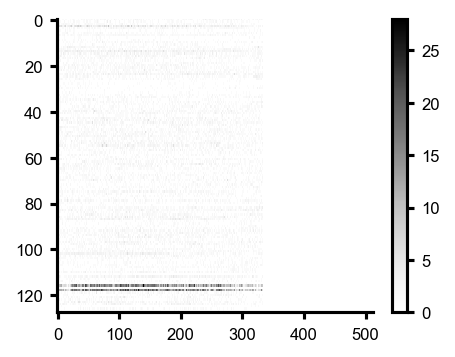

In [4]:
# visualize a datapoint
plt.imshow(train_dataloader.dataset[0]['signal'], aspect='auto', cmap='Greys')
plt.colorbar()

# the datapoint will be padded and masked to max_seqlen (512 here)

In [5]:
# set device to cuda if available, otherwise cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# initialize autoencoder model
ae = AutoEncoder(
    C_in=cfg.model.C_in,  # input channels (128 neurons)
    C=cfg.model.C,  # hidden dimension (256)
    C_latent=cfg.model.C_latent,  # latent dimension (32)
    L=cfg.dataset.max_seqlen,  # sequence length (512)
    num_blocks=cfg.model.num_blocks,  # number of encoder blocks (6)
    num_blocks_decoder=cfg.model.get("num_blocks_decoder", cfg.model.num_blocks),  # decoder blocks (6)
    num_lin_per_mlp=cfg.model.get("num_lin_per_mlp", 2),  # linear layers per mlp block
    bidirectional=cfg.model.get("bidirectional", False),  # unidirectional for causal modeling
)

# print model size
print("Number of params", sum(p.numel() for p in ae.parameters() if p.requires_grad)/1e6, "M")

# wrap model to track parameter counts
ae = CountWrapper(ae)
print(ae)

# move model to device
ae = ae.to(device)

# initialize optimizer with AdamW
optimizer = torch.optim.AdamW(
    ae.parameters(), lr=cfg.training.lr
)  # weight decay=0.01 by default

# set up learning rate scheduler
num_batches = len(train_dataloader)
lr_scheduler = get_scheduler(
    name="cosine",  # cosine annealing schedule
    optimizer=optimizer,
    num_warmup_steps=num_batches * cfg.training.num_warmup_epochs,  # warmup period
    num_training_steps=num_batches * cfg.training.num_epochs * 1.5,  # total training steps
)

# check if sequence length is power of 2 for FFT compatibility
if cfg.dataset.max_seqlen & (cfg.dataset.max_seqlen - 1) != 0:
    cfg.training.precision = "no"  # disable mixed precision if not power of 2

# initialize accelerator for mixed precision training
accelerator = accelerate.Accelerator(
    mixed_precision=cfg.training.precision,
)

# prepare model, optimizer and dataloaders for distributed training
(
    ae,
    optimizer,
    lr_scheduler,
    train_dataloader,
    val_dataloader,
    test_dataloader,
) = accelerator.prepare(
    ae,
    optimizer,
    lr_scheduler,
    train_dataloader,
    val_dataloader,
    test_dataloader,
)


Number of params 2.04816 M
CountWrapper(
  (ae_net): AutoEncoder(
    (encoder_in): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
    (encoder): ModuleList(
      (0-5): 6 x AutoEncoderBlock(
        (time_mixer): FFTConv(
          (activation): Identity()
          (kernel): SSMKernelDPLR()
          (drop): Identity()
          (drop_kernel): Identity()
        )
        (post_tm_scale): Conv1d(256, 256, kernel_size=(1,), stride=(1,), padding=same, groups=256)
        (channel_mixer): Sequential(
          (0): Rearrange('b c l -> b l c')
          (1): Linear(in_features=256, out_features=512, bias=False)
          (2): GELU(approximate='none')
          (3): Linear(in_features=512, out_features=256, bias=False)
          (4): Rearrange('b l c -> b c l')
        )
        (norm1): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (act1

In [7]:
# define poisson loss criterion for spike count prediction
# reduction="none" to apply masking later
criterion_poisson = torch.nn.PoissonNLLLoss(log_input=False, full=True, reduction="none")

def compute_val_loss(net, dataloader):
    """Compute validation loss and visualize predictions.
    
    Args:
        net: neural network model
        dataloader: validation data loader
        
    Returns:
        avg_poisson_loss: average poisson loss over validation set
    """
    # set model to evaluation mode
    net.eval()
    poisson_loss_total = 0
    batch_count = 0

    for batch in dataloader:
        signal = batch["signal"]  # shape: [batch, channels, time]
        signal_mask = batch["mask"].cpu()  # binary mask for valid timesteps
        
        # get model predictions without gradients
        with torch.no_grad():
            output_rates = net(signal)[0].cpu()  # predicted firing rates

        signal = signal.cpu()  # move signal to cpu for loss computation

        # compute poisson loss between predicted rates and true spike counts
        poisson_loss = criterion_poisson(output_rates, signal)
        # apply mask to only consider valid timesteps
        poisson_loss = poisson_loss * signal_mask
    
        # accumulate batch statistics
        poisson_loss_total += poisson_loss.mean().item()
        batch_count += 1

    # compute average loss over all batches, scaled by masking probability
    avg_poisson_loss = poisson_loss_total / batch_count * cfg.training.mask_prob
    print(f"Validation loss: {avg_poisson_loss:.4f}, mask_prob {cfg.training.mask_prob}")

    # visualize predictions vs ground truth for two example channels
    fig, ax = plt.subplots(2, 1, figsize=(10, 2), dpi=300)
    for row in range(2):  # plot two channels spaced 92 apart
        # plot predicted rates (clipped for visualization)
        ax[row].plot(output_rates[0, 92 * (row)].cpu().clip(0, 3).numpy(), label="pred")
        # plot true spike counts
        ax[row].plot(
            batch["signal"][0, 92 * (row)].cpu().clip(0, 3).numpy(),
            label="spikes",
            alpha=0.5,
            color="grey",
        )
        plt.legend()
    plt.close(fig)

    return avg_poisson_loss


In [49]:
from ldns.utils.plotting_utils import cm2inch
from einops import rearrange


def plot_rate_traces_real(model, dataloader, figsize=(12, 5), idx=0):
    """Plot predicted firing rates and spikes for selected channels.
    
    Args:
        model: trained autoencoder model
        dataloader: dataloader containing spike data
        figsize: figure size in cm (width, height)
        idx: index of example to plot
        
    Returns:
        None, displays plot
    """
    model.eval()
    # get first batch
    for batch in dataloader:
        signal = batch["signal"]
        signal_mask = batch["mask"].cpu()
        with torch.no_grad():
            output_rates = model(signal)[0].cpu()
        signal = signal.cpu()
        break

    # select 2 channels with highest firing rates
    mean_firing_rates = signal.mean(0).mean(0)
    channels = torch.argsort(mean_firing_rates, descending=True)[:2]

    fig, ax = plt.subplots(1, len(channels), figsize=cm2inch(figsize), dpi=150)

    for i, channel in enumerate(channels):
        L_actual = int(signal_mask[idx, channel].sum().item())
        L = batch["signal"][idx, channel].shape[0]
        
        # plot spike times as vertical lines
        ax[i].vlines(
            torch.arange(L_actual),
            torch.zeros(L_actual),
            torch.ones(L_actual) * output_rates[idx, channel, :L_actual].cpu().max().item(),
            color="black",
            alpha=np.min(
                np.stack(
                    (
                        np.ones(L_actual),
                        batch["signal"][idx, channel, :L_actual].cpu().numpy() * 0.1,
                    ),
                    axis=1,
                ),
                axis=1,
            ),
        )
        # plot predicted rates
        ax[i].plot(
            output_rates[idx, channel, :L_actual].cpu().numpy(),
            label="pred",
            color="red",
        )
        ax[i].set_title(f"channel {channel}")

    ax[-1].legend()
    fig.suptitle("rate traces for channels")
    fig.tight_layout()
    plt.show()


def imshow_rates_real(model, dataloader, figsize=(12, 5), idx=0):
    """Plot heatmaps comparing predicted rates to true spikes.
    
    Args:
        model: trained autoencoder model
        dataloader: dataloader containing spike data  
        figsize: figure size in cm (width, height)
        idx: index of example to plot
        
    Returns:
        None, displays plot
    """
    model.eval()
    # get first batch
    for batch in dataloader:
        signal = batch["signal"]
        signal_mask = batch["mask"].cpu()
        with torch.no_grad():
            output_rates = model(signal)[0].cpu()
        signal = signal.cpu()
        break

    fig, ax = plt.subplots(1, 2, figsize=cm2inch(figsize), dpi=150)

    L_actual = int(batch["mask"][idx, 0].sum().item())

    # plot predicted rates
    im1 = ax[0].imshow(
        output_rates[idx, :, :L_actual].cpu().numpy(),
        label="rates",
        aspect="auto",
        cmap="Greys",
    )
    # plot true spikes
    im2 = ax[1].imshow(
        signal[idx, :, :L_actual].cpu().numpy(),
        label="rates",
        aspect="auto",
        cmap="Greys",
    )
    plt.colorbar(im1, ax=ax[0])
    plt.colorbar(im2, ax=ax[1])

    ax[-1].legend()
    ax[0].set_title("Inferred rates")
    ax[1].set_title("Spikes")

    fig.suptitle(f"infeered rates, idx {idx}")
    fig.tight_layout()
    plt.show()



## training loop

In [ ]:
# train loop
criterion_poisson = torch.nn.PoissonNLLLoss(log_input=False, full=True, reduction="none")

# initialize lists to track losses and learning rates
rec_losses, latent_losses, total_losses, lrs, val_rate_losses = [], [], [], [], []
avg_poisson_loss, avg_rate_loss = 0, 0

with tqdm(range(0, cfg.training.num_epochs)) as pbar:
    for epoch in pbar:
        ae.train()

        for i, data in enumerate(train_dataloader):
            optimizer.zero_grad()

            signal = data["signal"]
            signal_mask = data["mask"]
            L_actual = signal_mask[:, 0, :].sum(-1)

            # applying mask (coordinated dropout)
            mask_prob = cfg.training.get("mask_prob", 0.25)
            
            # create random mask and scale unmasked values
            mask = (
                torch.rand_like(signal[:]) > mask_prob
            ).float()  # if mask_prob=0.2, 80% will be 1 and rest 0
            input_signal = signal * (
                mask / (1 - mask_prob)
            )  # mask and scale unmasked by 1/(1-p)

            # forward pass
            output_rates, z = ae(input_signal)

            numel = signal.shape[0] * signal.shape[1] * signal.shape[2]

            # computing loss on masked parts
            unmasked = (1 - mask) if mask_prob > 0 else torch.ones_like(mask)
            poisson_loss = criterion_poisson(output_rates, signal) * unmasked

            # mask out padding
            poisson_loss = poisson_loss * signal_mask
            poisson_loss = poisson_loss.mean()

            rec_loss = poisson_loss

            # compute latent regularization loss
            latent_loss = latent_regularizer(z, cfg) / numel
            loss = rec_loss + cfg.training.latent_beta * latent_loss

            # optimization step
            accelerator.backward(loss)
            accelerator.clip_grad_norm_(ae.parameters(), 2.0)
            optimizer.step()
            lr_scheduler.step()

            # update progress bar
            pbar.set_postfix(
                **{
                    "rec_loss": rec_loss.item(),
                    "latent_loss": latent_loss.item(), 
                    "total_loss": loss.item(),
                    "lr": optimizer.param_groups[0]["lr"],
                    "val_poisson_loss": avg_poisson_loss,
                }
            )

            # track metrics
            rec_losses.append(rec_loss.item())
            latent_losses.append(latent_loss.item())
            total_losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]["lr"])

        # validation loop
        if accelerator.is_main_process and (
            (epoch) % 10 == 0 or epoch == cfg.training.num_epochs - 1
        ):
            avg_poisson_loss = compute_val_loss(ae, val_dataloader)

        # visualization and checkpointing
        if accelerator.is_main_process and (
            (epoch) % 20 == 0 or epoch == cfg.training.num_epochs - 1
        ):
            ae.eval()
            plot_rate_traces_real(ae, val_dataloader, figsize=(12, 5), idx=1)
            imshow_rates_real(ae, val_dataloader, figsize=(12, 5), idx=1)
            

In [ ]:
# save checkpoint
torch.save(accelerator.unwrap_model(ae).state_dict(), f"exp/{cfg.exp_name}/model.pt")

We use the trained autoencoder for diffusion model training in `notebooks/train_diffusion_human.ipynb`.